### QLearning 更新

我们回到之前的流程, 根据 Q 表的估计, 因为在 s1 中, a2 的值比较大, 通过之前的决策方法, 我们在 s1 采取了 a2, 并到达 s2, 这时我们开始更新用于决策的 Q 表, 接着我们并没有在实际中采取任何行为, 而是再想象自己在 s2 上采取了每种行为, 分别看看两种行为哪一个的 Q 值大, 比如说 Q(s2, a2) 的值比 Q(s2, a1) 的大, 所以我们把大的 Q(s2, a2) 乘上一个衰减值 gamma (比如是0.9) 并加上到达s2时所获取的奖励 R (这里还没有获取到我们的棒棒糖, 所以奖励为 0), 因为会获取实实在在的奖励 R , 我们将这个作为我现实中 Q(s1, a2) 的值, 但是我们之前是根据 Q 表估计 Q(s1, a2) 的值. 所以有了现实和估计值, 我们就能更新Q(s1, a2) , 根据 估计与现实的差距, 将这个差距乘以一个学习效率 alpha 累加上老的 Q(s1, a2) 的值 变成新的值. **但时刻记住, 我们虽然用 maxQ(s2) 估算了一下 s2 状态, 但还没有在 s2 做出任何的行为, s2 的行为决策要等到更新完了以后再重新另外做.** 这就是 off-policy 的 Q learning 是如何决策和学习优化决策的过程.

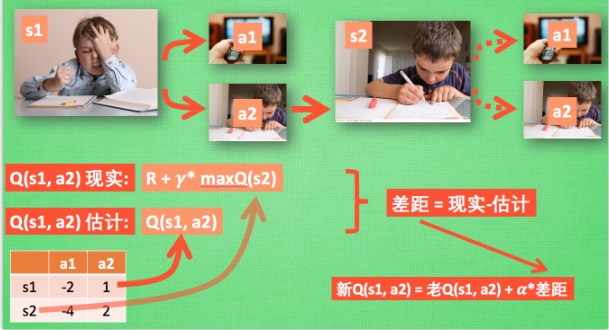

实现QLearning的算法：
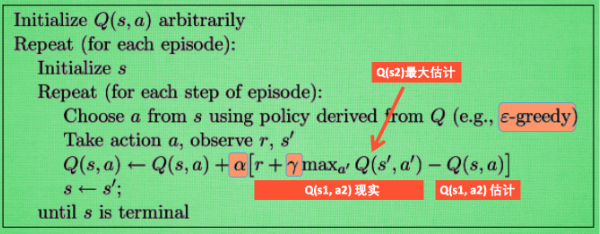

In [ ]:
"""
This part of code is the Q learning brain, which is a brain of the agent.
All decisions are made in here.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""

import numpy as np
import pandas as pd


class QLearningTable:
    #learning_rate:对应α，reward_decay：对应γ，e_greedy：对应ε
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        #初始化Q表是空的，表的列为actions的名字，行（对应state）为空
        #后面check_state_exist时，会检查之前是否遇到过这个状态，没有，就加入Q表
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        if np.random.uniform() < self.epsilon:
            # choose best action
            state_action = self.q_table.loc[observation, :]
            # some actions may have the same value, randomly choose on in these actions
            action = np.random.choice(state_action[state_action == np.max(state_action)].index)
            # 上面代码也可以这样写：
            # state_action = self.q_table.loc[observation, :]
            # state_action = state_action.reindex(np.random.permutation(state_action_index))
            # action = state_action.argmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)
        return action

    # state action reward next_state
    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions), #把全零的值append到Q表中
                    index=self.q_table.columns,
                    name=state,
                )
            )

In [ ]:
"""
This part of code is the Q learning brain, which is a brain of the agent.
All decisions are made in here.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""

import numpy as np
import pandas as pd


class QLearningTable:
    #learning_rate:对应α，reward_decay：对应γ，e_greedy：对应ε
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        #初始化Q表是空的，后面check_state_exist时，会检查之前是否遇到过这个状态，没有，就加入Q表
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        if np.random.uniform() < self.epsilon:
            # choose best action
            state_action = self.q_table.loc[observation, :]
            # some actions may have the same value, randomly choose on in these actions
            action = np.random.choice(state_action[state_action == np.max(state_action)].index)
        else:
            # choose random action
            action = np.random.choice(self.actions)
        return action

    # state action reward next_state
    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

In [2]:
"""
Reinforcement learning maze example.
Red rectangle:          explorer.
Black rectangles:       hells       [reward = -1].
Yellow bin circle:      paradise    [reward = +1].
All other states:       ground      [reward = 0].
This script is the environment part of this example. The RL is in RL_brain.py.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""


import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk


UNIT = 40   # pixels
MAZE_H = 4  # grid height
MAZE_W = 4  # grid width


class Maze(tk.Tk, object):
    def __init__(self):
        super(Maze, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))
        self._build_maze()

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 2, UNIT])
        self.hell1 = self.canvas.create_rectangle(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        # hell
        hell2_center = origin + np.array([UNIT, UNIT * 2])
        self.hell2 = self.canvas.create_rectangle(
            hell2_center[0] - 15, hell2_center[1] - 15,
            hell2_center[0] + 15, hell2_center[1] + 15,
            fill='black')

        # create oval
        oval_center = origin + UNIT * 2
        self.oval = self.canvas.create_oval(
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()

    def reset(self):
        self.update()
        time.sleep(0.5)
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        # return observation
        return self.canvas.coords(self.rect)

    def step(self, action):
        s = self.canvas.coords(self.rect)
        base_action = np.array([0, 0])
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        s_ = self.canvas.coords(self.rect)  # next state

        # reward function
        if s_ == self.canvas.coords(self.oval):
            reward = 1
            done = True
            s_ = 'terminal'
        elif s_ in [self.canvas.coords(self.hell1), self.canvas.coords(self.hell2)]:
            reward = -1
            done = True
            s_ = 'terminal'
        else:
            reward = 0
            done = False

        return s_, reward, done

    def render(self):
        time.sleep(0.1)
        self.update()


def update():
    for t in range(10):
        s = env.reset()
        while True:
            env.render()
            a = 1
            s, r, done = env.step(a)
            if done:
                break

#if __name__ == '__main__':
#    env = Maze()
#    env.after(100, update)
#    env.mainloop()

In [4]:
"""
Reinforcement learning maze example.
Red rectangle:          explorer.
Black rectangles:       hells       [reward = -1].
Yellow bin circle:      paradise    [reward = +1].
All other states:       ground      [reward = 0].
This script is the main part which controls the update method of this example.
The RL is in RL_brain.py.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""
#from maze_env import Maze
#from RL_brain import QLearningTable

def update():
    for episode in range(100): #100个回合
        # initial observation
        observation = env.reset()

        while True:
            # fresh env
            env.render()

            # RL choose action based on observation
            action = RL.choose_action(str(observation))

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            # RL learn from this transition（一大步）
            RL.learn(str(observation), action, reward, str(observation_))

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break

    # end of game
    print('game over')
    env.destroy()

if __name__ == "__main__":
    env = Maze()
    RL = QLearningTable(actions=list(range(env.n_actions)))

    env.after(100, update)
    env.mainloop()

game over
